<h1>Fashion-MNIST Project </h1>

<h2 id="Preparation" >Preparation</h2>

The following are the PyTorch modules to use

In [ ]:
!pip install torch
!pip install torchvision

In [1]:
# PyTorch Modules needed

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
torch.manual_seed(0)

Import Non-PyTorch Modules 

In [2]:
# Other non-PyTorch Modules

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

from PIL import Image

In [3]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<hr>

<hr>

###  Create a Dataset Class

In this section, you will load a Dataset object, but first you must transform the dataset. Use the <code>Compose</code> function to perform the following transforms:. 
<ol>
    <li>use the transforms object to<code> Resize </code> to resize the image.</li>
    <li>use the transforms object to<code> ToTensor </code> to convert the image to a tensor.</li>
</ol>


In [4]:
# Size of the images are 16 by 16
IMAGE_SIZE = 16

# Creating a group of transformations to created a rotated dataset
# Resizes the images, randomly rotates it, and then converts it to a tensor
compose_rotate = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.RandomAffine(45), transforms.ToTensor()])

# Creating a group of transformations to created a non rotated dataset
# Resizes the images then converts it to a tensor
compose = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

<hr>

Create two dataset objects for the Fashion MNIST  dataset. One for training data called <code> dataset_train </code> and one for validation data <code>dataset_val</code>. 

In [5]:
# The transform parameters is set to the corresponding compose
train_dataset_rotate = dsets.FashionMNIST(root='.fashion/data', train=True, download=True, transform=compose_rotate)
train_dataset = dsets.FashionMNIST(root='.fashion/data', train=True, download=True, transform=compose)

validation_dataset_rotate = dsets.FashionMNIST(root='.fashion/data', train=False, download=True, transform=compose_rotate)
validation_dataset = dsets.FashionMNIST(root='.fashion/data', train=False, download=True, transform=compose)

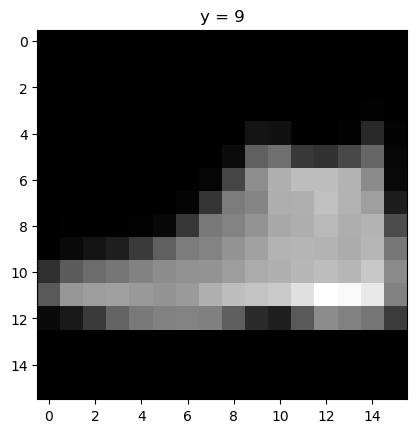

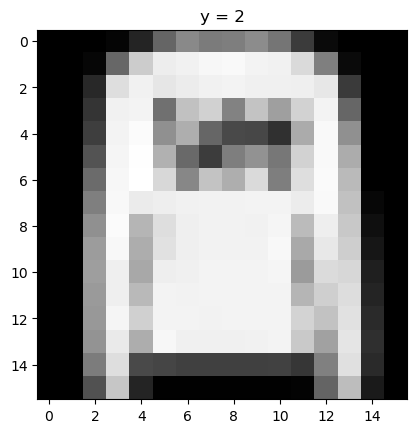

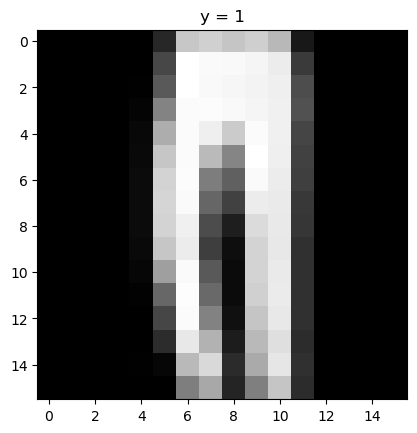

In [6]:
for n,data_sample in enumerate(validation_dataset):

    show_data(data_sample)
    plt.show()
    if n==2:
        break 

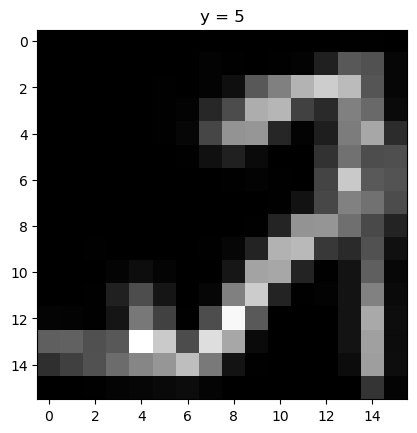

In [7]:
show_data(train_dataset[8])

Create a Convolutional Neural Network class.  Train the network 

In [8]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

Constructor  for regular Convolutional Neural Network

In [9]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

train loader  and validation loader 

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100 )
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100 )

Convolutional Neural Network object 

In [21]:
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32,number_of_classes=10)
model_batch =CNN_batch(out_1=16, out_2=32,number_of_classes=10)
#model = CNN(out_1=16, out_2=32)

Create the objects for the criterion and the optimizer named <code>criterion</code> and <code>optimizer</code>. 

In [22]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Code used to train the model 

In [23]:
import time
start_time = time.time()

cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
n_epochs=5
for epoch in range(n_epochs):
    cost=0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost+=loss.item()
    correct=0
    #perform a prediction on the validation  data 
    model.eval()
    for x_test, y_test in validation_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)
    
    
   

You will use the following to plot the Cost and accuracy for each epoch for the training and testing data, respectively. 

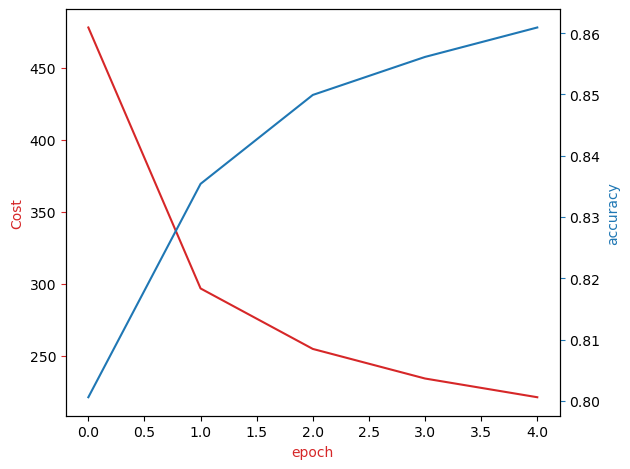

In [24]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [25]:
def plot_mis_classified(model, dataset):
    count=0
    for x, y in torch.utils.data.DataLoader(dataset=dataset, batch_size=1):
        z = model(x)
        _, yhat = torch.max(z, 1)
        if yhat != y:
            show_data((x, y))
            plt.show()
            count += 1
        if count >= 5:
            break 

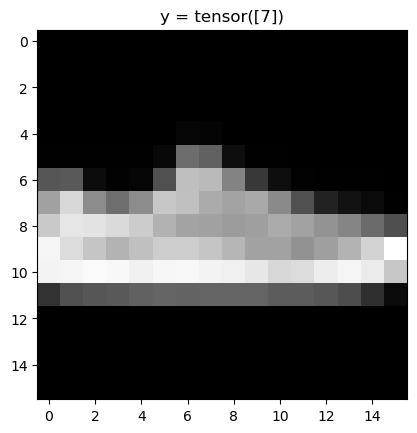

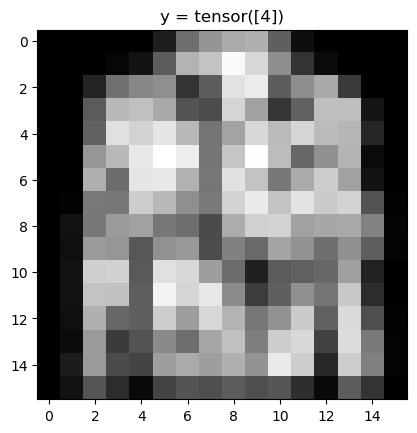

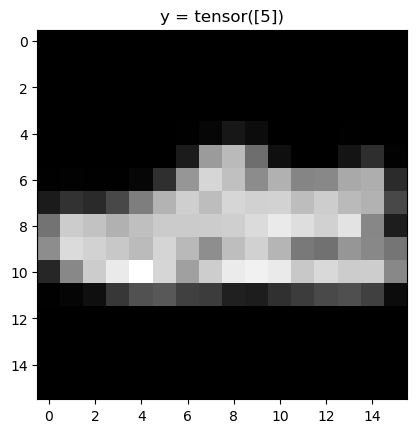

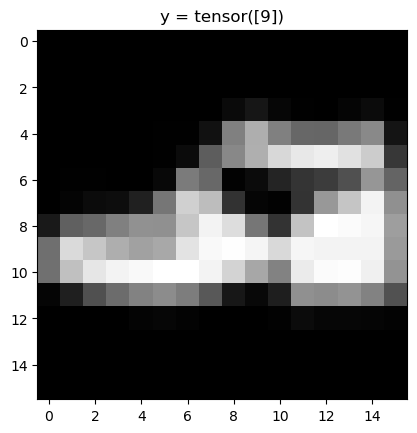

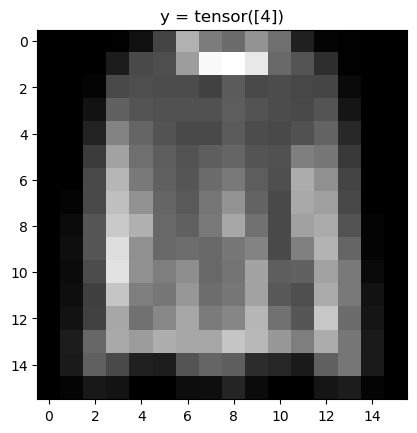

In [26]:
plot_mis_classified(model,validation_dataset)